### Google Colab

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
%cd "/content/drive/MyDrive/4_ING_INFORMATICA/tfg/tfg/experiments/taming_transformers/taming-transformers/"

UsageError: Line magic function `%` not found.


In [ ]:
% % capture
% pip install omegaconf >= 2.0.0 pytorch-lightning >= 1.0.8 einops >= 0.3.0

### NGPU server

In [1]:
%cd "/mnt/homeGPU1/pbedmar/pycharm/experiments/taming_transformers/taming-transformers/"

/mnt/homeGPU1/pbedmar/pycharm/experiments/taming_transformers/taming-transformers


In [2]:
import sys

sys.path.append(".")

# also disable grad to save memory
import torch

torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/mnt/homeGPU1/pbedmar/pbedmar.tfg.taming.train/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


#### Functions to load and preprocess models

In [3]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

torch.manual_seed(1)


def load_config(config_path, display=False):
    config = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config)))
    return config


def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    if is_gumbel:
        model = GumbelVQ(**config.model.params)
    else:
        model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(sd, strict=False)
    return model.eval()


def preprocess_vqgan(x):
    x = 2. * x - 1.
    return x


def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.) / 2.
    x = x.permute(1, 2, 0).numpy()
    x = (255 * x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x


def reconstruct_with_vqgan(x, model):
    # could also use model(x) for reconstruction but use explicit encoding and decoding here
    z, _, [_, _, indices] = model.encode(x)
    print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
    xrec = model.decode(z)
    return xrec

#### Load trained models

In [4]:
project_path = "experiments/taming_transformers/taming-transformers/"
models = []
#titles=["Input", "VQGAN - 192x192 - 8ep", "VQGAN - 192x192 - 16ep", "VQGAN - 192x192 - 32ep", "VQGAN aug - 192x192 - 40ep", "VQGAN aug - 192x192 - 70ep", "VQGAN aug - 192x192 - 100ep", "VQGAN aug - 192x192 - 150ep", "VQGAN aug - 192x192 - 200ep", "VQGAN aug - 192x192 - 300ep"]
titles = ["Input", "VQGAN aug - 192x192 - 40ep", "VQGAN aug - 192x192 - 70ep", "VQGAN aug - 192x192 - 100ep",
          "VQGAN aug - 192x192 - 150ep", "VQGAN aug - 192x192 - 200ep", "VQGAN aug - 192x192 - 300ep",
          "VQGAN aug - 192x192 - 400ep", "VQGAN aug - 192x192 - 500ep"]

#config_8ep = load_config("logs/2022-03-10T13-17-06_custom_vqgan/configs/2022-03-10T13-17-06-project.yaml", display=False)
#model_8ep = load_vqgan(config_8ep, ckpt_path="logs/2022-03-10T13-17-06_custom_vqgan/checkpoints/last.ckpt").to(DEVICE)
#models.append(model_8ep)

#config_16ep = load_config("logs/2022-03-13T12-11-25_custom_vqgan/configs/2022-03-13T12-11-25-project.yaml", display=False)
#model_16ep = load_vqgan(config_16ep, ckpt_path="logs/2022-03-13T12-11-25_custom_vqgan/checkpoints/last.ckpt").to(DEVICE)
#models.append(model_16ep)

#config_32ep = load_config("logs/2022-03-13T12-44-33_custom_vqgan/configs/2022-03-13T12-44-33-project.yaml", display=False)
#model_32ep = load_vqgan(config_32ep, ckpt_path="logs/2022-03-13T12-44-33_custom_vqgan/checkpoints/last.ckpt").to(DEVICE)
#models.append(model_32ep)

config_aug_40ep = load_config("logs/2022-03-14T08-43-25_custom_vqgan_aug/configs/2022-03-14T08-43-25-project.yaml",
                              display=False)
model_aug_40ep = load_vqgan(config_aug_40ep,
                            ckpt_path="logs/2022-03-14T08-43-25_custom_vqgan_aug/checkpoints/last.ckpt").to(DEVICE)
models.append(model_aug_40ep)

config_aug_70ep = load_config("logs/2022-03-15T19-39-05_custom_vqgan_aug/configs/2022-03-15T19-39-05-project.yaml",
                              display=False)
model_aug_70ep = load_vqgan(config_aug_70ep,
                            ckpt_path="logs/2022-03-15T19-39-05_custom_vqgan_aug/checkpoints/last.ckpt").to(DEVICE)
models.append(model_aug_70ep)

config_aug_100ep = load_config("logs/2022-03-24T00-27-34_custom_vqgan_aug/configs/2022-03-24T00-27-34-project.yaml",
                               display=False)
model_aug_100ep = load_vqgan(config_aug_100ep,
                             ckpt_path="logs/2022-03-24T00-27-34_custom_vqgan_aug/checkpoints/last.ckpt").to(DEVICE)
models.append(model_aug_100ep)

config_aug_150ep = load_config("logs/2022-03-24T06-37-39_custom_vqgan_aug/configs/2022-03-24T06-37-39-project.yaml",
                               display=False)
model_aug_150ep = load_vqgan(config_aug_150ep,
                             ckpt_path="logs/2022-03-24T06-37-39_custom_vqgan_aug/checkpoints/last.ckpt").to(DEVICE)
models.append(model_aug_150ep)

config_aug_200ep = load_config("logs/2022-03-23T21-38-37_custom_vqgan_aug/configs/2022-03-23T21-38-37-project.yaml",
                               display=False)
model_aug_200ep = load_vqgan(config_aug_200ep,
                             ckpt_path="logs/2022-03-23T21-38-37_custom_vqgan_aug/checkpoints/last.ckpt").to(DEVICE)
models.append(model_aug_200ep)

config_aug_300ep = load_config("logs/2022-03-24T01-44-05_custom_vqgan_aug/configs/2022-03-24T01-44-05-project.yaml",
                               display=False)
model_aug_300ep = load_vqgan(config_aug_300ep,
                             ckpt_path="logs/2022-03-24T01-44-05_custom_vqgan_aug/checkpoints/last.ckpt").to(DEVICE)
models.append(model_aug_300ep)

config_aug_400ep = load_config("logs/2022-03-26T14-25-50_custom_vqgan_aug/configs/2022-03-26T14-25-50-project.yaml",
                               display=False)
model_aug_400ep = load_vqgan(config_aug_400ep,
                             ckpt_path="logs/2022-03-26T14-25-50_custom_vqgan_aug/checkpoints/last.ckpt").to(DEVICE)
models.append(model_aug_400ep)

config_aug_500ep = load_config("logs/2022-03-26T14-26-01_custom_vqgan_aug/configs/2022-03-26T14-26-01-project.yaml",
                               display=False)
model_aug_500ep = load_vqgan(config_aug_500ep,
                             ckpt_path="logs/2022-03-26T14-26-01_custom_vqgan_aug/checkpoints/last.ckpt").to(DEVICE)
models.append(model_aug_500ep)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pr

In [8]:
models2 = []
titles2 = ["Input", "VQGAN aug 2 - 192x192 - 40ep", "VQGAN aug 2 - 192x192 - 70ep", "VQGAN aug 2 - 192x192 - 100ep",
           "VQGAN aug 2 - 192x192 - 150ep", "VQGAN aug 2 - 192x192 - 200ep", "VQGAN aug 2 - 192x192 - 300ep"]

config_aug2_40ep = load_config("logs/2022-03-24T14-47-40_custom_vqgan_aug_2/configs/2022-03-24T14-47-40-project.yaml",
                               display=False)
model_aug2_40ep = load_vqgan(config_aug2_40ep,
                             ckpt_path="logs/2022-03-24T14-47-40_custom_vqgan_aug_2/checkpoints/last.ckpt").to(DEVICE)
models2.append(model_aug2_40ep)

config_aug2_70ep = load_config("logs/2022-03-24T15-24-33_custom_vqgan_aug_2/configs/2022-03-24T15-24-33-project.yaml",
                               display=False)
model_aug2_70ep = load_vqgan(config_aug2_70ep,
                             ckpt_path="logs/2022-03-24T15-24-33_custom_vqgan_aug_2/checkpoints/last.ckpt").to(DEVICE)
models2.append(model_aug2_70ep)

config_aug2_100ep = load_config("logs/2022-03-24T16-30-14_custom_vqgan_aug_2/configs/2022-03-24T16-30-14-project.yaml",
                                display=False)
model_aug2_100ep = load_vqgan(config_aug2_100ep,
                              ckpt_path="logs/2022-03-24T16-30-14_custom_vqgan_aug_2/checkpoints/last.ckpt").to(DEVICE)
models2.append(model_aug2_100ep)

config_aug2_150ep = load_config("logs/2022-03-24T22-59-22_custom_vqgan_aug_2/configs/2022-03-24T22-59-22-project.yaml",
                                display=False)
model_aug2_150ep = load_vqgan(config_aug2_150ep,
                              ckpt_path="logs/2022-03-24T22-59-22_custom_vqgan_aug_2/checkpoints/last.ckpt").to(DEVICE)
models2.append(model_aug2_150ep)

config_aug2_200ep = load_config("logs/2022-03-25T01-30-44_custom_vqgan_aug_2/configs/2022-03-25T01-30-44-project.yaml",
                                display=False)
model_aug2_200ep = load_vqgan(config_aug2_200ep,
                              ckpt_path="logs/2022-03-25T01-30-44_custom_vqgan_aug_2/checkpoints/last.ckpt").to(DEVICE)
models2.append(model_aug2_200ep)

config_aug2_300ep = load_config("logs/2022-03-25T05-09-50_custom_vqgan_aug_2/configs/2022-03-25T05-09-50-project.yaml",
                                display=False)
model_aug2_300ep = load_vqgan(config_aug2_300ep,
                              ckpt_path="logs/2022-03-25T05-09-50_custom_vqgan_aug_2/checkpoints/last.ckpt").to(DEVICE)
models2.append(model_aug2_300ep)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pr

In [5]:
models3 = []
titles3 = ["Input", "VQGAN aug 3 - 192x192 - 70ep", "VQGAN aug 3 - 192x192 - 110ep", "VQGAN aug 3 - 192x192 - 130ep", "VQGAN aug 3 - 192x192 - 150ep", "VQGAN aug 3 - 192x192 - 170ep"]

directory = "2022-03-29T23-24-34"
config_aug3_70ep = load_config("logs/"+directory+"_custom_vqgan_aug_3/configs/"+directory+"-project.yaml", display=False)
model_aug3_70ep = load_vqgan(config_aug3_70ep, ckpt_path="logs/"+directory+"_custom_vqgan_aug_3/checkpoints/last.ckpt").to(DEVICE)
models3.append(model_aug3_70ep)

# directory = "2022-03-30T08-43-49"
# config_aug3_90ep = load_config("logs/"+directory+"_custom_vqgan_aug_3/configs/"+directory+"-project.yaml", display=False)
# model_aug3_90ep = load_vqgan(config_aug3_90ep, ckpt_path="logs/"+directory+"_custom_vqgan_aug_3/checkpoints/last.ckpt").to(DEVICE)
# models3.append(model_aug3_90ep)

directory = "2022-03-29T23-29-08"
config_aug3_110ep = load_config("logs/"+directory+"_custom_vqgan_aug_3/configs/"+directory+"-project.yaml", display=False)
model_aug3_110ep = load_vqgan(config_aug3_110ep, ckpt_path="logs/"+directory+"_custom_vqgan_aug_3/checkpoints/last.ckpt").to(DEVICE)
models3.append(model_aug3_110ep)

directory = "2022-03-30T00-31-12"
config_aug3_130ep = load_config("logs/"+directory+"_custom_vqgan_aug_3/configs/"+directory+"-project.yaml", display=False)
model_aug3_130ep = load_vqgan(config_aug3_130ep, ckpt_path="logs/"+directory+"_custom_vqgan_aug_3/checkpoints/last.ckpt").to(DEVICE)
models3.append(model_aug3_130ep)

directory = "2022-03-30T01-17-21"
config_aug3_150ep = load_config("logs/"+directory+"_custom_vqgan_aug_3/configs/"+directory+"-project.yaml", display=False)
model_aug3_150ep = load_vqgan(config_aug3_150ep, ckpt_path="logs/"+directory+"_custom_vqgan_aug_3/checkpoints/last.ckpt").to(DEVICE)
models3.append(model_aug3_150ep)

directory = "2022-03-30T02-44-43"
config_aug3_170ep = load_config("logs/"+directory+"_custom_vqgan_aug_3/configs/"+directory+"-project.yaml", display=False)
model_aug3_170ep = load_vqgan(config_aug3_170ep, ckpt_path="logs/"+directory+"_custom_vqgan_aug_3/checkpoints/last.ckpt").to(DEVICE)
models3.append(model_aug3_170ep)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


#### Auxiliary functions to sample images

In [6]:
import io
import os
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-BoldOblique.ttf", 10)


def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=192, map_dalle=True):
    s = min(img.size)

    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')

    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    print("Unsqueezed:", img.shape)
    return img


def stack_reconstructions(images, titles=[]):
    w, h = images[0].size[0], images[0].size[1]
    img = Image.new("RGB", (len(images) * w, h))
    for i, image in enumerate(images):
        img.paste(image, (i * w, 0))

    for i, title in enumerate(titles):
        ImageDraw.Draw(img).text((i * w, 0), f'{title}', (0, 0, 0), font=font)  # coordinates, text, color, font
    return img

#### Reconstruction pipelines to sample images

In [7]:
#titles=["Input", "VQGAN - 192x192 - 8ep", "VQGAN - 192x192 - 16ep", "VQGAN - 192x192 - 32ep", "VQGAN aug - 192x192 - 40ep", "VQGAN aug - 192x192 - 70ep", "VQGAN aug - 192x192 - 100ep", "VQGAN aug - 192x192 - 150ep", "VQGAN aug - 192x192 - 200ep", "VQGAN aug - 192x192 - 300ep"]

def reconstruction_pipeline_fixed_data(file, size=192, origin_format=0, models=models, titles=titles):
    if origin_format == 0:
        x_vqgan = preprocess(download_image(file), target_image_size=size, map_dalle=False)
    elif origin_format == 1:
        file = PIL.Image.open(file)
        x_vqgan = preprocess(file, target_image_size=size, map_dalle=False)
    else:
        x_vqgan = file

    x_vqgan = x_vqgan.to(DEVICE)

    print(f"input is of size: {x_vqgan.shape}")

    pils = []
    pils.append(custom_to_pil(preprocess_vqgan(x_vqgan[0])))
    for m in models:
        pils.append(custom_to_pil(reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), m)[0]))

    img = stack_reconstructions(pils, titles)
    return img


def reconstruction_pipeline_fixed_model(model, files, title, size=192):
    pils = []

    for f in files:
        if f[1] == 0:
            x_vqgan = preprocess(download_image(f[0]), target_image_size=size, map_dalle=False)
        elif f[1] == 1:
            file = PIL.Image.open(f[0])
            x_vqgan = preprocess(file, target_image_size=size, map_dalle=False)
        else:
            x_vqgan = f[0]

        x_vqgan = x_vqgan.to(DEVICE)

        pils.append((custom_to_pil(preprocess_vqgan(x_vqgan[0])),
                     custom_to_pil(reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model)[0])))

    img = Image.new("RGB", (2 * size, len(pils) * size))
    for i, image in enumerate(pils):
        img.paste(image[0], (0, i * size))
        img.paste(image[1], (size, i * size))

    ImageDraw.Draw(img).text((0, 0), f'{title}', (0, 0, 0), font=font)  # coordinates, text, color, font

    return img


def reconstruction_pipeline(models, files, titles, size=192):

    img = Image.new("RGB", ((1 + len(models)) * size, len(files) * size))

    for i, f in enumerate(files):
        if f[1] == 0:
            x_vqgan = preprocess(download_image(f[0]), target_image_size=size, map_dalle=False)
        elif f[1] == 1:
            file = PIL.Image.open(f[0])
            x_vqgan = preprocess(file, target_image_size=size, map_dalle=False)
        else:
            x_vqgan = f[0]

        x_vqgan = x_vqgan.to(DEVICE)

        pils = []
        pils.append(custom_to_pil(preprocess_vqgan(x_vqgan[0])))
        for m in models:
            pils.append(custom_to_pil(reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), m)[0]))

        for j, image in enumerate(pils):
            img.paste(image, (j * size, i * size))
            if i == 0:
                ImageDraw.Draw(img).text((j * size, 0), f'{titles[j]}', (0, 0, 0), font=font)  # coordinates, text, color, font

    return img

#### Perlin noise generator

In [8]:
#perlin noise implementation - URL:https://stackoverflow.com/questions/42147776/producing-2d-perlin-noise-with-numpy - 25/3/22

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)


def perlin(x, y):
    # permutation table
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    # coordinates of the top-left
    xi, yi = x.astype(int), y.astype(int)
    # internal coordinates
    xf, yf = x - xi, y - yi
    # fade factors
    u, v = fade(xf), fade(yf)
    # noise components
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    # combine noises
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)  # FIX1: I was using n10 instead of n01
    return lerp(x1, x2, v)  # FIX2: I also had to reverse x1 and x2 here


def lerp(a, b, x):
    "linear interpolation"
    return a + x * (b - a)


def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3


def gradient(h, x, y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y


lin = np.linspace(0, 5, 192, endpoint=False)
x, y = np.meshgrid(lin, lin)  # FIX3: I thought I had to invert x and y here but it was a mistake

#plt.imshow(perlin(x, y, seed=2), origin='upper')

#### Generate perlin noise samples

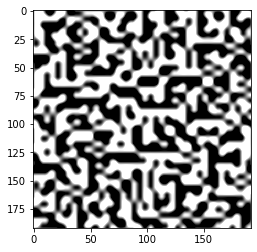

In [12]:
amp = [1,3,5,7]
freq = [1,2,4]

for a in amp:
    for f in freq:
        noise = a * perlin(f * x, f * y)
        plt.imshow(noise, vmin=-1, vmax=1, cmap='gray')
        plt.imsave("../../../datasets/sample/perlin_python_" + str(a) + "_" + str(f) + ".jpg", noise, vmin=-1, vmax=1,
           cmap='gray')

#### Load data used to sample

In [9]:
validation_data = []

validation_data.append(
    ('https://assets.fishersci.com/TFS-Assets/CCG/Chemical-Structures/chemical-structure-cas-67-64-1.jpg-650.jpg', 0))
validation_data.append(('https://i.pinimg.com/736x/3f/26/21/3f2621fa39b9ed4706ba1edba07d61c5.jpg', 0))
validation_data.append((torch.rand(1, 3, 192, 192), 2))
validation_data.append((torch.rand(1, 3, 192, 192), 2))
validation_data.append((
                       "https://img.myloview.es/posters/checkered-chequered-squares-pattern-and-background-chessboard-chess-checkerboard-texture-pattern-simple-and-basic-monochrome-pepita-alternating-squares-backdrop-400-225411586.jpg",
                       0))
validation_data.append(("../../../datasets/sample/perlin_python_1_1.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_1_2.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_1_4.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_3_1.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_3_2.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_3_4.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_5_1.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_5_2.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_5_4.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_7_1.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_7_2.jpg", 1))
validation_data.append(("../../../datasets/sample/perlin_python_7_4.jpg", 1))
validation_data.append(("../../../datasets/sample/turbulence.jpg", 1))
validation_data.append(("../../../datasets/sample/30.jpg", 1))
validation_data.append(("../../../datasets/sample/31.jpg", 1))
validation_data.append(("../../../datasets/sample/32.jpg", 1))
validation_data.append(("../../../datasets/sample/33.jpg", 1))
validation_data.append(("../../../datasets/sample/34.jpg", 1))

#### reconstruction_pipeline() experiments


In [13]:
path = "../validation/aug/"
os.makedirs(path, exist_ok=True)
img = reconstruction_pipeline(models, validation_data, titles, size=192)
img.save(path+"aug1.jpg")

Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


In [14]:
path = "../validation/aug2/"
os.makedirs(path, exist_ok=True)
img = reconstruction_pipeline(models2, validation_data, titles2, size=192)
img.save(path+"aug2.jpg")

Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


In [10]:
path = "../validation/aug3/"
os.makedirs(path, exist_ok=True)
img = reconstruction_pipeline(models3, validation_data, titles3, size=192)
img.save(path+"aug3.jpg")

Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


#### reconstruction_pipeline_fixed_data() experiments

In [77]:
path = "../validation/aug/"
os.makedirs(path, exist_ok=True)
for i, v in enumerate(validation_data):
    img = reconstruction_pipeline_fixed_data(v[0], origin_format=v[1])
    img.save(path + str(i) + ".jpg")

path = "../validation/aug2/"
os.makedirs(path, exist_ok=True)
for i, v in enumerate(validation_data):
    img = reconstruction_pipeline_fixed_data(v[0], origin_format=v[1], models=models2, titles=titles2)
    img.save(path + str(i) + ".jpg")

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: la

VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQMo

#### reconstruction_pipeline_fixed_model() experiments

Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
Unsqueezed: torch.Size([1, 3, 192, 19

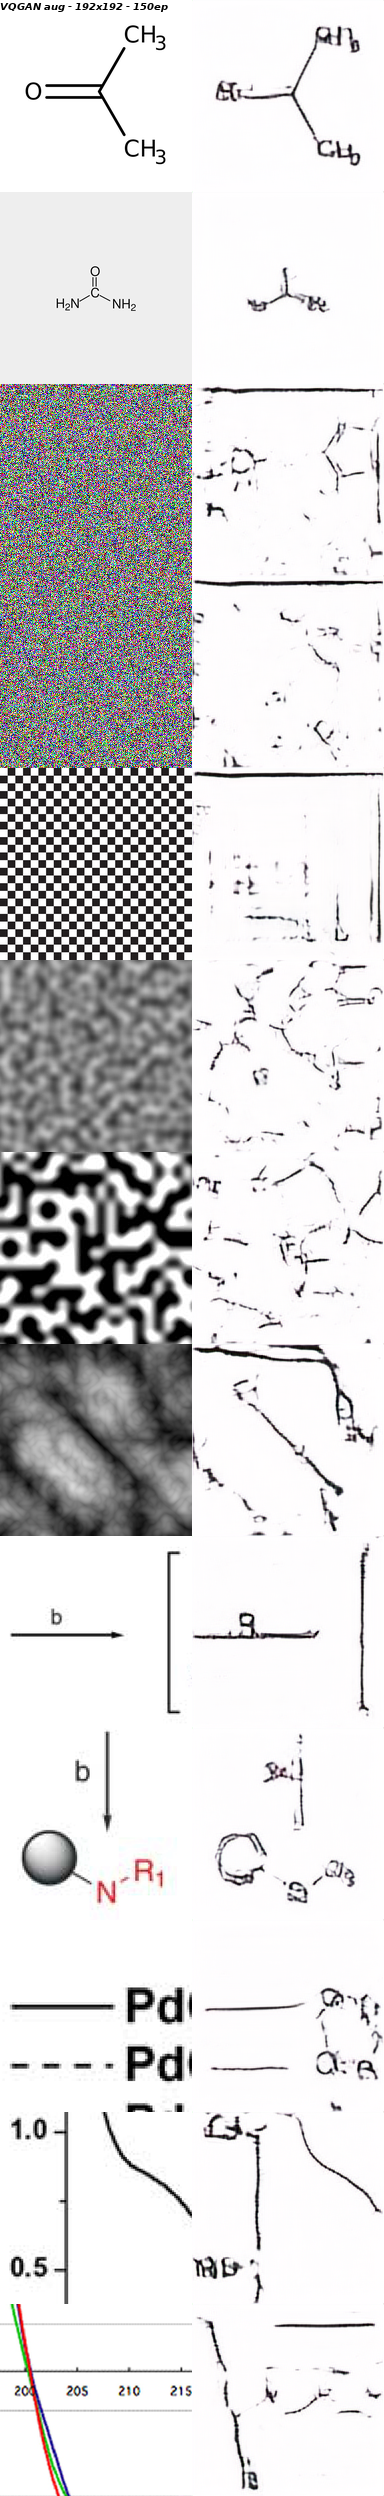

In [131]:
reconstruction_pipeline_fixed_model(model_aug_150ep, validation_data, "VQGAN aug - 192x192 - 150ep")

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


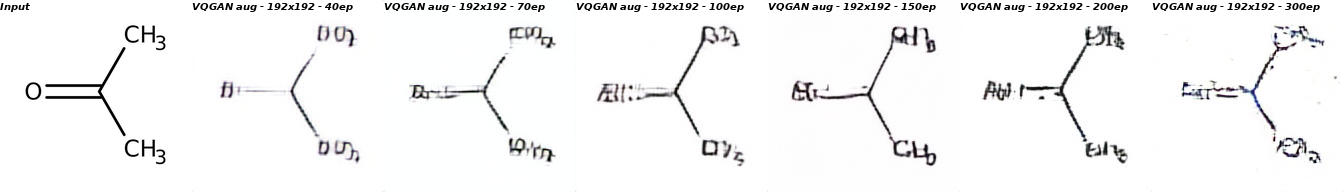

In [29]:
reconstruction_pipeline_fixed_data(
    'https://assets.fishersci.com/TFS-Assets/CCG/Chemical-Structures/chemical-structure-cas-67-64-1.jpg-650.jpg')

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


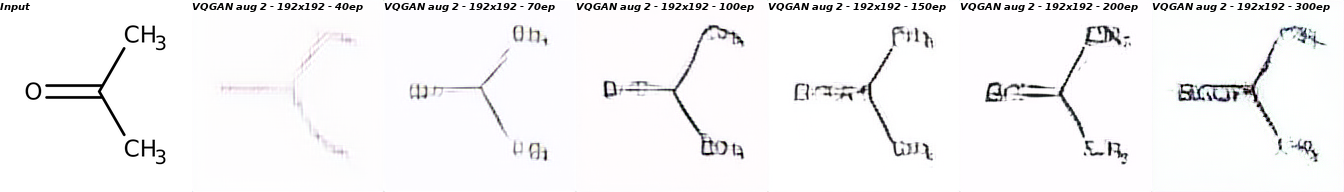

In [30]:
reconstruction_pipeline_fixed_data(
    'https://assets.fishersci.com/TFS-Assets/CCG/Chemical-Structures/chemical-structure-cas-67-64-1.jpg-650.jpg',
    models=models2, titles=titles2)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


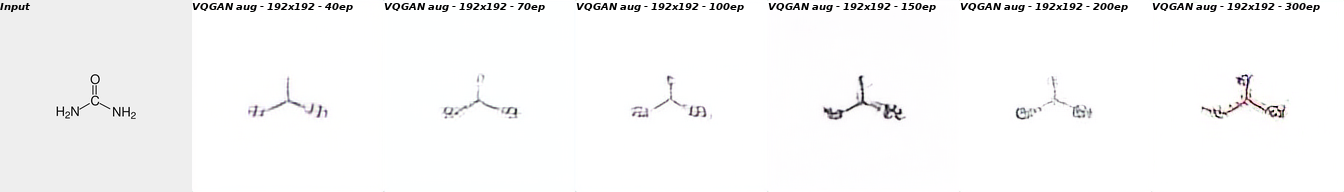

In [31]:
reconstruction_pipeline_fixed_data('https://i.pinimg.com/736x/3f/26/21/3f2621fa39b9ed4706ba1edba07d61c5.jpg')

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


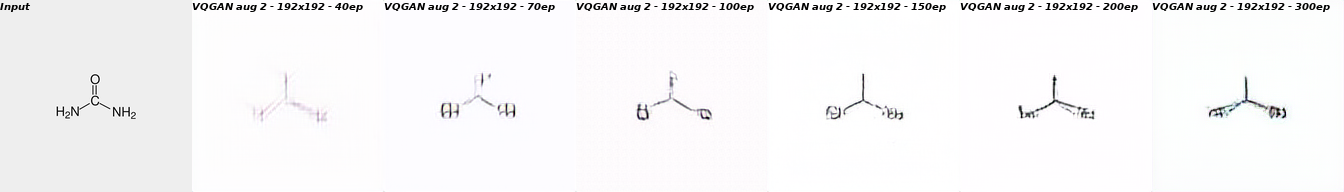

In [32]:
reconstruction_pipeline_fixed_data('https://i.pinimg.com/736x/3f/26/21/3f2621fa39b9ed4706ba1edba07d61c5.jpg',
                                   models=models2, titles=titles2)

input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


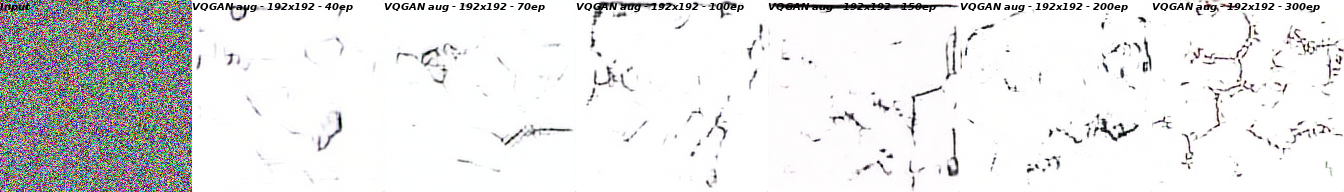

In [33]:
random_noise = torch.rand(1, 3, 192, 192)
reconstruction_pipeline_fixed_data(random_noise, origin_format=2)

input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


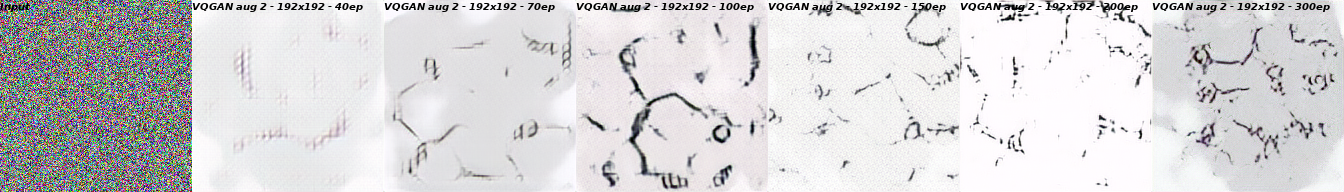

In [34]:
reconstruction_pipeline_fixed_data(random_noise, origin_format=2, models=models2, titles=titles2)

tensor([[[[0.1024, 0.4538, 0.0786,  ..., 0.8668, 0.3724, 0.9484],
          [0.2939, 0.3498, 0.3062,  ..., 0.8297, 0.9105, 0.6530],
          [0.5504, 0.5032, 0.9075,  ..., 0.7233, 0.2194, 0.8587],
          ...,
          [0.9445, 0.3478, 0.5002,  ..., 0.1243, 0.3398, 0.8593],
          [0.0880, 0.4103, 0.3070,  ..., 0.3319, 0.7240, 0.4054],
          [0.8620, 0.0688, 0.9383,  ..., 0.4570, 0.7531, 0.8896]],

         [[0.4680, 0.4646, 0.3132,  ..., 0.5423, 0.2289, 0.4929],
          [0.8955, 0.8256, 0.6862,  ..., 0.7464, 0.0667, 0.9306],
          [0.6650, 0.9946, 0.1622,  ..., 0.8802, 0.6870, 0.5922],
          ...,
          [0.5852, 0.9623, 0.1013,  ..., 0.6161, 0.0848, 0.0732],
          [0.1813, 0.1032, 0.0981,  ..., 0.9588, 0.5490, 0.3223],
          [0.2545, 0.9651, 0.2141,  ..., 0.1884, 0.7219, 0.3106]],

         [[0.6735, 0.5760, 0.6700,  ..., 0.7386, 0.4414, 0.0143],
          [0.0582, 0.7337, 0.3171,  ..., 0.0260, 0.9508, 0.2000],
          [0.1743, 0.1403, 0.3789,  ..., 0

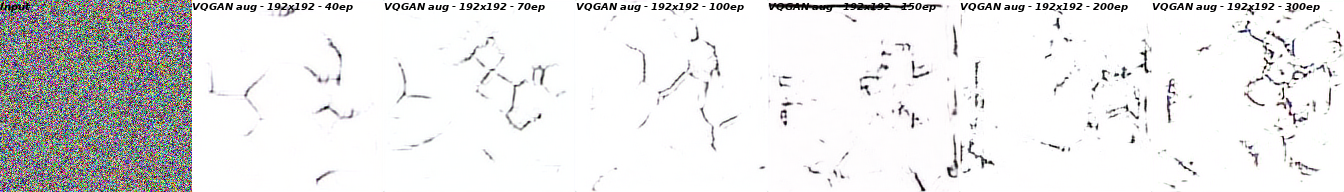

In [35]:
random_noise2 = torch.rand(1, 3, 192, 192)
print(random_noise2)
reconstruction_pipeline_fixed_data(random_noise2, origin_format=2)

input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


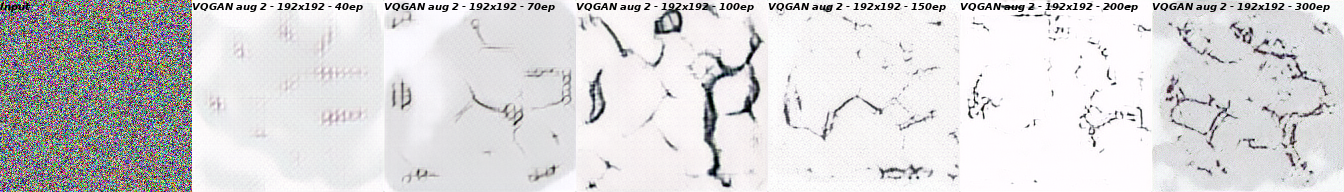

In [36]:
reconstruction_pipeline_fixed_data(random_noise2, origin_format=2, models=models2, titles=titles2)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


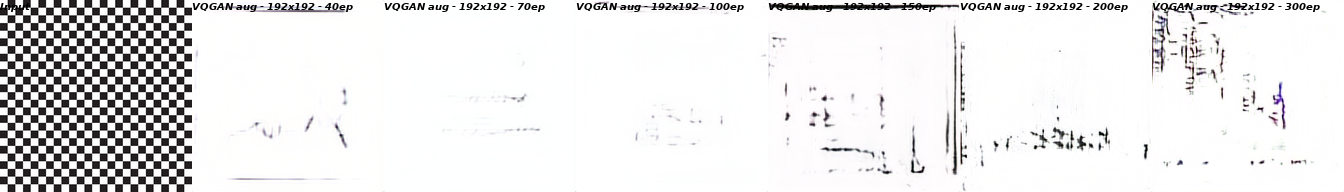

In [37]:
reconstruction_pipeline_fixed_data(
    "https://img.myloview.es/posters/checkered-chequered-squares-pattern-and-background-chessboard-chess-checkerboard-texture-pattern-simple-and-basic-monochrome-pepita-alternating-squares-backdrop-400-225411586.jpg")

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


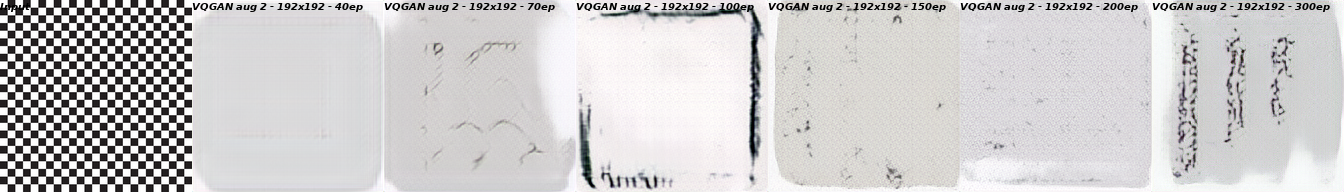

In [38]:
reconstruction_pipeline_fixed_data(
    "https://img.myloview.es/posters/checkered-chequered-squares-pattern-and-background-chessboard-chess-checkerboard-texture-pattern-simple-and-basic-monochrome-pepita-alternating-squares-backdrop-400-225411586.jpg",
    models=models2, titles=titles2)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


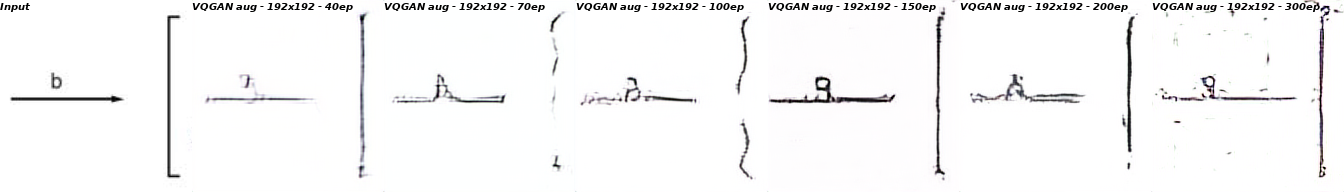

In [39]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/30.jpg", origin_format=1)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


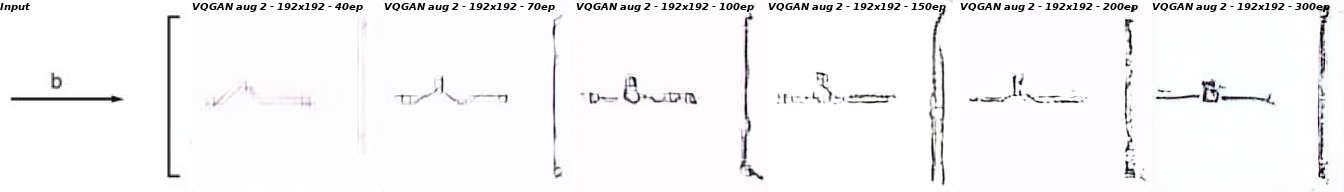

In [40]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/30.jpg", origin_format=1, models=models2, titles=titles2)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


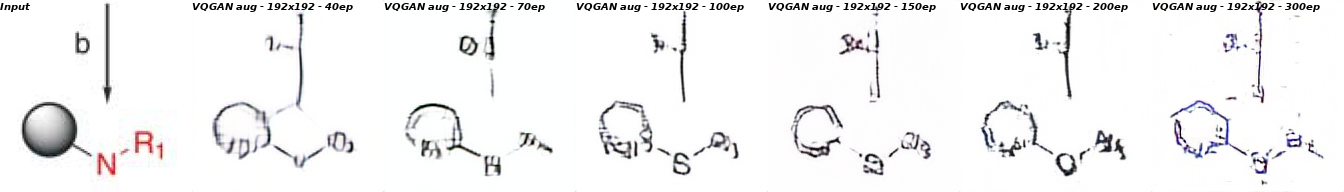

In [41]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/31.jpg", origin_format=1)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


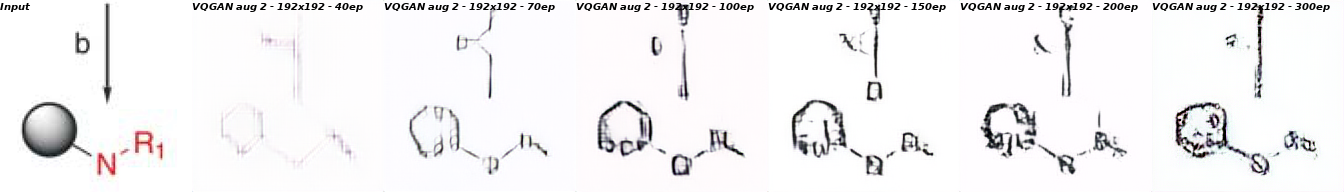

In [42]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/31.jpg", origin_format=1, models=models2, titles=titles2)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


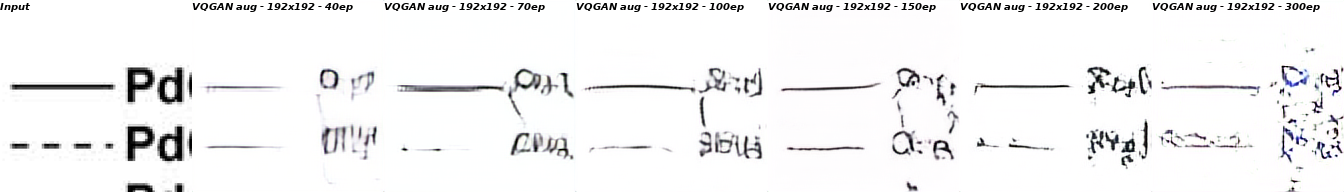

In [43]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/32.jpg", origin_format=1)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


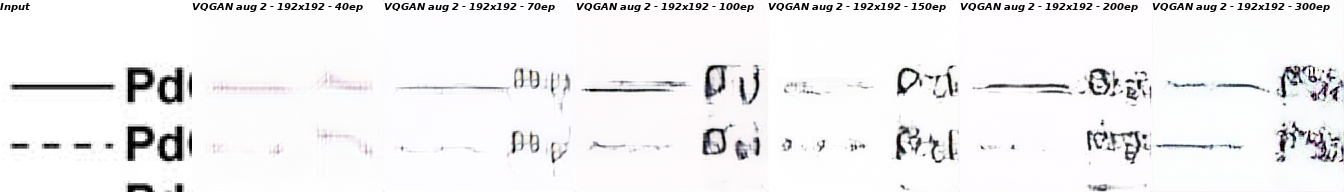

In [44]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/32.jpg", origin_format=1, models=models2, titles=titles2)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


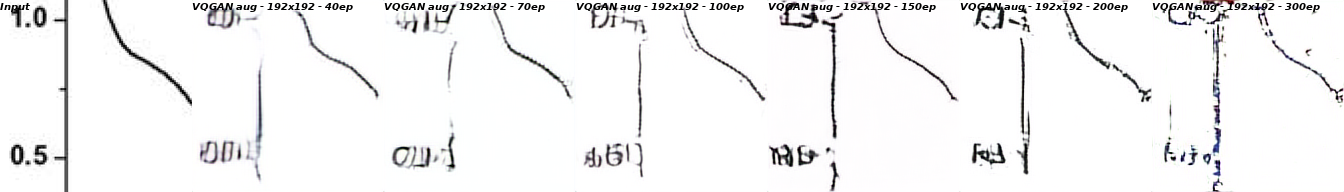

In [45]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/33.jpg", origin_format=1)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


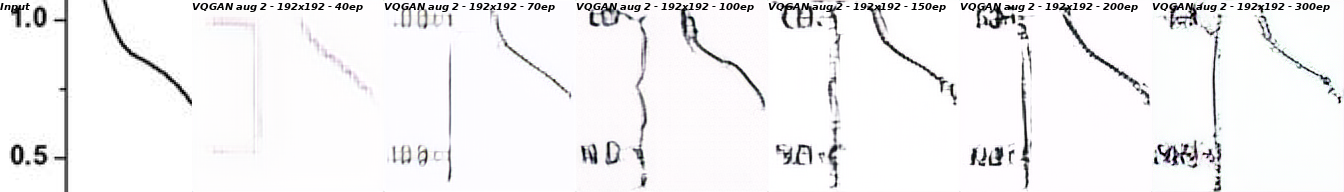

In [46]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/33.jpg", origin_format=1, models=models2, titles=titles2)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


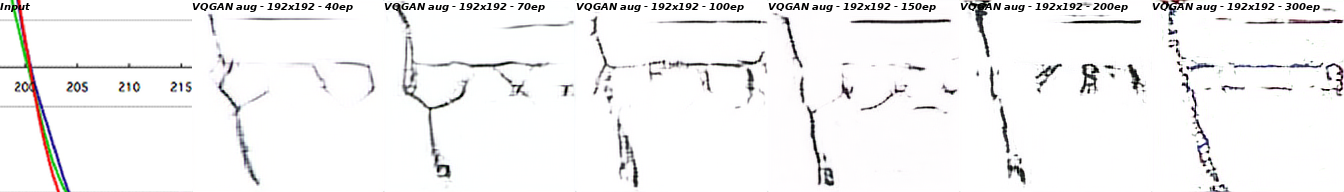

In [47]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/34.jpg", origin_format=1)

Unsqueezed: torch.Size([1, 3, 192, 192])
input is of size: torch.Size([1, 3, 192, 192])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])
VQGAN --- VQModel: latent shape: torch.Size([12, 12])


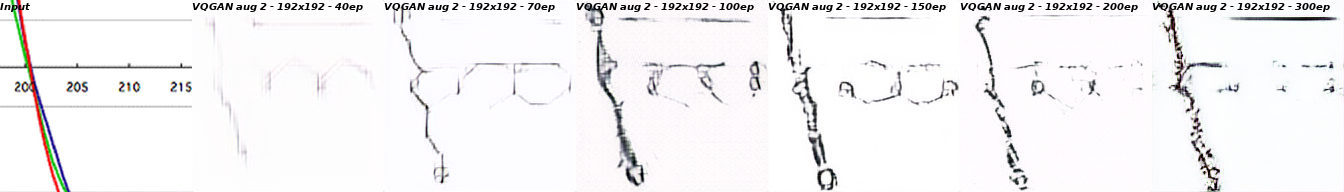

In [48]:
reconstruction_pipeline_fixed_data("../../../datasets/negev/34.jpg", origin_format=1, models=models2, titles=titles2)